# Project : Fake Tweets with Avg-W2v

In [1]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

from spellchecker import SpellChecker

Using TensorFlow backend.


In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

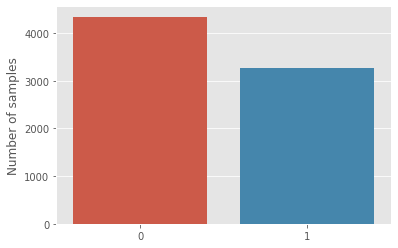

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

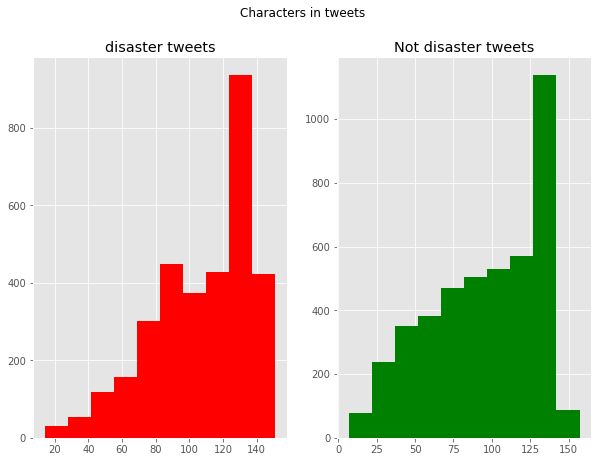

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

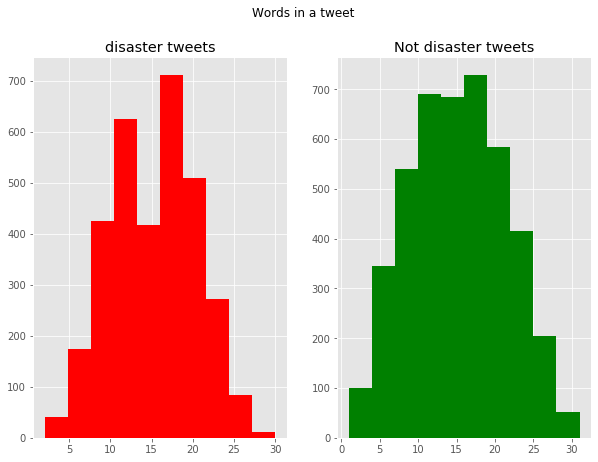

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

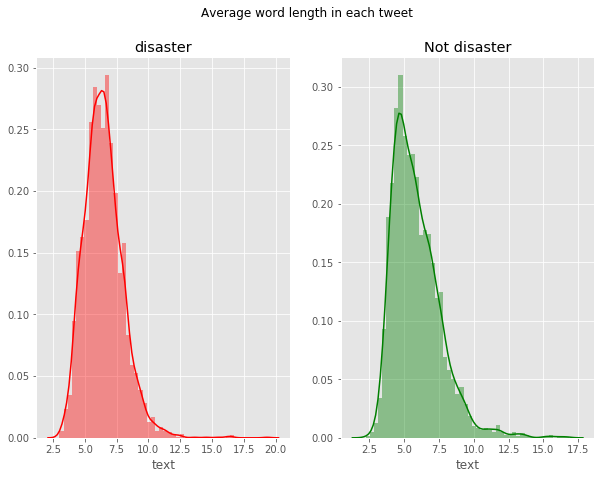

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [13]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [14]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [15]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Chicago, IL
Australia
California
New York, NY
California, USA
Everywhere
Florida


In [16]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [17]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [18]:
corpus = create_corpus(1)

In [19]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

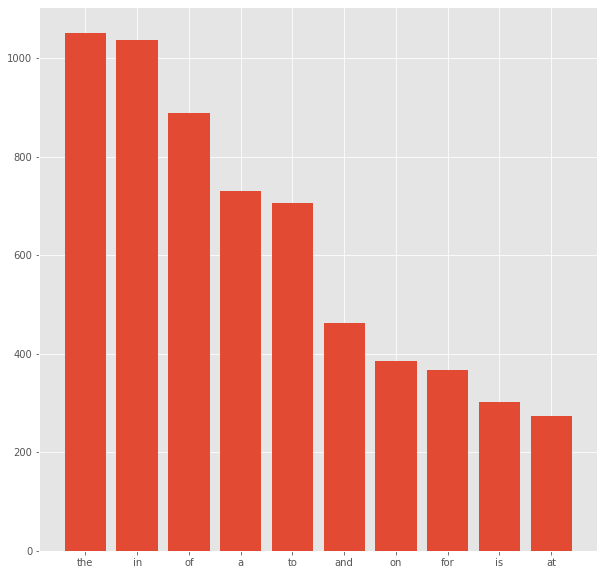

In [20]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

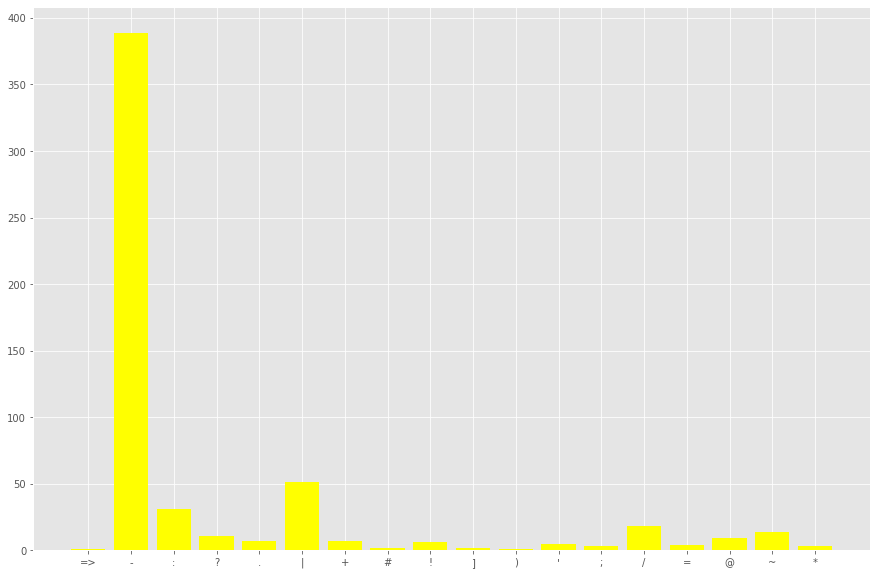

In [21]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

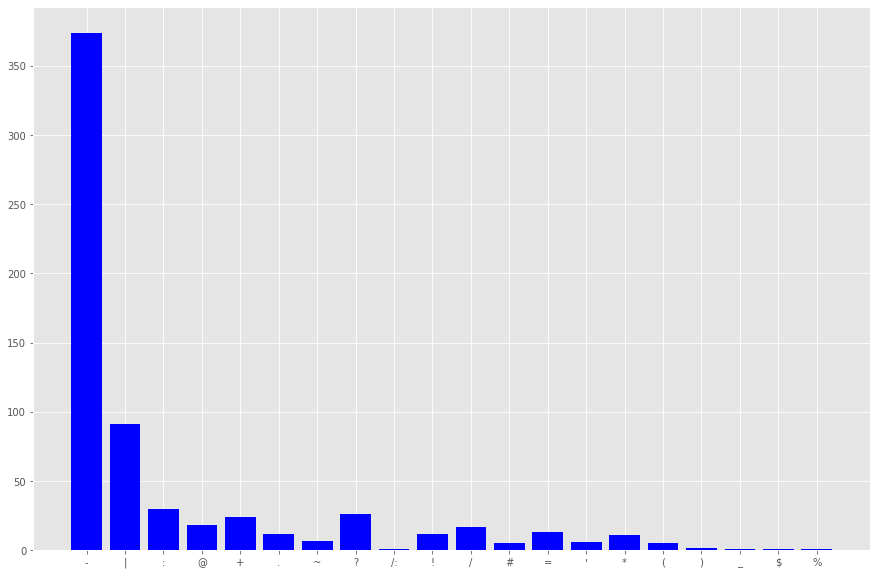

In [22]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [23]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

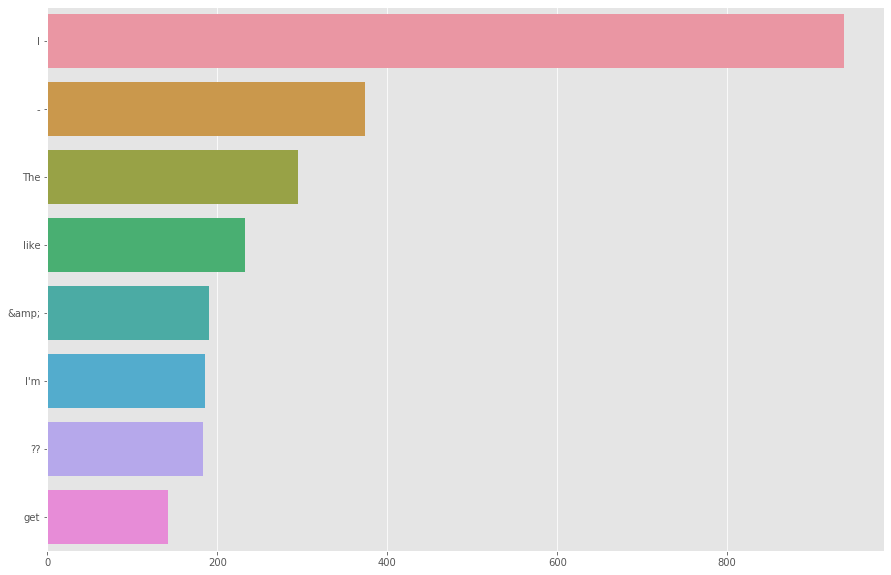

In [24]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [25]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words(Optional)

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [26]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [27]:
df_new.shape

(10876, 5)

In [28]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
text           0
target      3263
dtype: int64

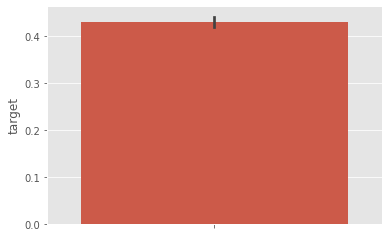

In [29]:
sns.barplot(y = 'target' , data = df_new)

In [30]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1.0
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1.0


In [31]:
df_new.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [32]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [33]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [34]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing URLS

In [35]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [36]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [37]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [38]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

### Remove Emoji's

In [39]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [40]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [41]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

### Remove Punctuations

In [42]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [43]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [44]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [45]:
train['text'][12]

'raining flooding Florida TampaBay Tampa 18 or 19 days Ive lost count '

In [46]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [47]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


### Spelling corrections

In [48]:
# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

In [49]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [50]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


In [51]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1.0
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


## Convert Text to W2V

In [52]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [53]:
x

,id,text
0,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Forest fire near La Ronge Sask Canada
2,5,All residents asked to shelter in place are be...
3,6,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...
7609,10870,ariaahrary TheTawniest The out of control wild...
7610,10871,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,Police investigating after an ebike collided w...


In [54]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My citya...
3260,10868,NaN,NaN,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO


In [55]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,Just happened a terrible car crash
1,2,Heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane My citya...
3260,10868,Green Line derailment in Chicago
3261,10874,MEG issues Hazardous Weather Outlook HWO


In [56]:
final_test.shape

(3263, 2)

In [57]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [58]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### W2V on Text


#### At first convert every single word to vector.Then apply AVG-W2V method convert text to numeric value

In [59]:
# X_Train

import gensim
i=0
list_of_sent_x_train=[]
for sent in tqdm(x_train['text'].values):
    filtered_sentence=[]
    sent = remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):   
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_x_train.append(filtered_sentence)

100%|██████████| 6090/6090 [00:00<00:00, 10564.64it/s]


In [60]:
w2v_model = gensim.models.Word2Vec(list_of_sent_x_train)

In [61]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

2268


In [62]:
# Convert x_train_w2v to avg-w2v

sent_vectors_x_train = []; 

for sent in tqdm(list_of_sent_x_train):
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_x_train.append(sent_vec) 

print(len(sent_vectors_x_train))
print(len(sent_vectors_x_train[0]))

100%|██████████| 6090/6090 [00:02<00:00, 2258.24it/s]

6090
100


In [63]:
# X_test

import gensim
i=0
list_of_sent_x_test = []
for sent in tqdm(x_test['text'].values):
    filtered_sentence=[]
    sent=remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):   
                filtered_sentence.append(cleaned_words.lower()) 
            else:
                continue 
    list_of_sent_x_test.append(filtered_sentence)

100%|██████████| 1523/1523 [00:00<00:00, 13882.78it/s]


In [64]:
# Convert x_test_w2v to avg-w2v

sent_vectors_x_test = []; 

for sent in tqdm(list_of_sent_x_test):
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_x_test.append(sent_vec) 

print(len(sent_vectors_x_test))
print(len(sent_vectors_x_test[0]))

100%|██████████| 1523/1523 [00:00<00:00, 2156.88it/s]

1523
100


In [65]:
# Test

import gensim
i=0

list_of_sent_test=[]
for sent in tqdm(test['text'].values):
    filtered_sentence=[]
    sent=remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████| 3263/3263 [00:00<00:00, 11726.59it/s]


In [66]:
# Convert test_w2v to avg-w2v

sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
    
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 3263/3263 [00:01<00:00, 1776.18it/s]

3263
100


In [67]:
x_train_w2v = sent_vectors_x_train
x_test_w2v = sent_vectors_x_test
test_w2v = sent_vectors_test

In [68]:
print("**W2V Vectorizer**")
print("="*50)


print(x_train_w2v[0])
print(x_test_w2v[0])
print(test_w2v[0])

**W2V Vectorizer**
[-0.19113481 -0.1525377   0.35332768 -0.04970082 -0.03410545 -0.25612433
 -0.27662267  0.03087372  0.35105385  0.43189367  0.23849829 -0.0526807
  0.2461854   0.29148095  0.11589916  0.09388697 -0.02692365  0.11061768
 -0.01954447 -0.05222208 -0.16956433 -0.35664278  0.02291842  0.11087663
  0.1299945   0.43096347  0.18888283 -0.0797581  -0.20943065 -0.23797027
 -0.01316721  0.0157676  -0.05142244  0.07936856  0.19685583  0.09383971
  0.04387614  0.01809526 -0.3614986   0.00146256  0.05510528 -0.0143713
  0.0096063  -0.14551568 -0.12800035  0.04993991  0.14760628  0.17644457
  0.24484607  0.0562307  -0.34454393  0.10085512 -0.16371814 -0.16513903
  0.02459577  0.09713599 -0.20275298 -0.02461239 -0.13154506 -0.1005071
 -0.11370036 -0.18798757  0.03830506  0.07979493 -0.20165695 -0.02926089
 -0.00594959 -0.16096549 -0.09604007  0.04511001  0.12321855 -0.02426404
 -0.05242494  0.22999939  0.0816127  -0.17216754  0.24442943  0.00834869
 -0.14453075 -0.0189175  -0.0504121

## Apply DIfferent ML model on AVG-W2V

## Logistic Regression on AVG-W2V

In [71]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(x_train_w2v)
X_test = sc.transform(x_test_w2v)
Test = sc.transform(test_w2v)

In [72]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


In [73]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [74]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

59.55351280367695


***Test Data Report***
Best C =  0.0001
AUC =  50.69004734605402


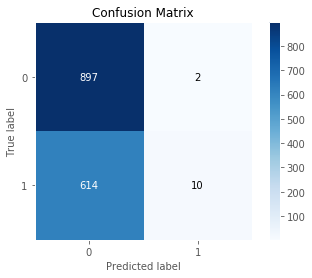

In [75]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [85]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

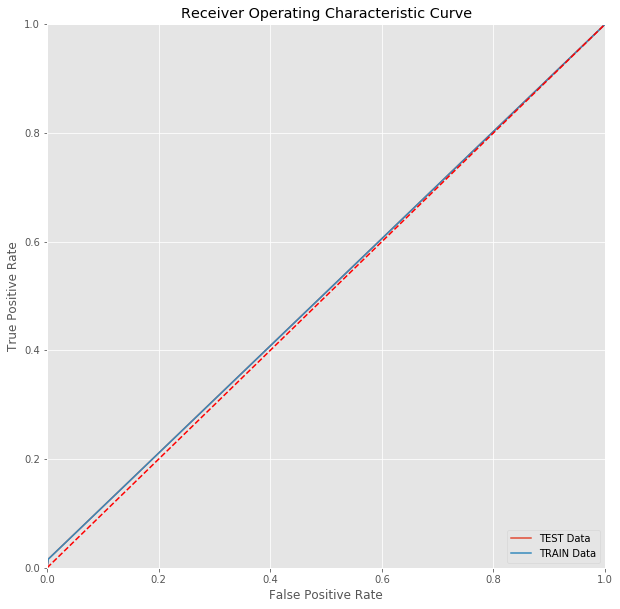

In [86]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

NameError: name 'count_vect' is not defined

In [ ]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

In [ ]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [ ]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on AVG-W2V

In [87]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

67.56401838476691


In [88]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [89]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.296808      0.018663         1.730971        0.032354   
1       0.310569      0.016285         1.923462        0.069974   
2       0.353452      0.013180         1.862022        0.158099   
3       0.305181      0.017186         1.802980        0.138370   
4       0.306979      0.038360         2.192446        0.585901   

  param_n_neighbors               params  split0_test_score  \
0                 2   {'n_neighbors': 2}           0.661741   
1                 4   {'n_neighbors': 4}           0.665025   
2                 6   {'n_neighbors': 6}           0.669951   
3                 8   {'n_neighbors': 8}           0.679803   
4                10  {'n_neighbors': 10}           0.673235   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.676519           0.661741           0.664204  ...   
1           0.675698           0.678161           0.659278  ...   
2           0.675

In [90]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.296808,0.018663,1.730971,0.032354,2,{'n_neighbors': 2},0.661741,0.676519,0.661741,0.664204,...,0.660755,0.011925,24,0.827381,0.828612,0.824713,0.825123,0.831897,0.827545,0.002607
1,0.310569,0.016285,1.923462,0.069974,4,{'n_neighbors': 4},0.665025,0.675698,0.678161,0.659278,...,0.665681,0.010351,21,0.777504,0.782020,0.776273,0.774425,0.788998,0.779844,0.005218
2,0.353452,0.013180,1.862022,0.158099,6,{'n_neighbors': 6},0.669951,0.675698,0.669130,0.655172,...,0.663218,0.010885,23,0.755542,0.759031,0.756363,0.754105,0.762110,0.757430,0.002836
3,0.305181,0.017186,1.802980,0.138370,8,{'n_neighbors': 8},0.679803,0.678982,0.674056,0.669130,...,0.670936,0.009885,2,0.737685,0.745074,0.745074,0.746100,0.749179,0.744622,0.003781
4,0.306979,0.038360,2.192446,0.585901,10,{'n_neighbors': 10},0.673235,0.684729,0.669130,0.665025,...,0.669787,0.009236,5,0.726396,0.733785,0.734195,0.731732,0.735222,0.732266,0.003147


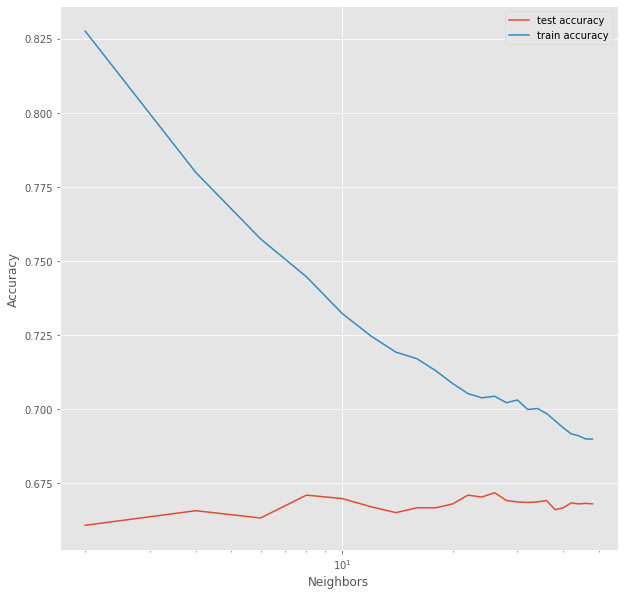

In [91]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [92]:
knn = KNeighborsClassifier(n_neighbors = 12 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

After Cross-validation:  67.56401838476691


## Naive-Bayes on AVG-W2V

In [80]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00, 10.44it/s]


In [81]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.001.


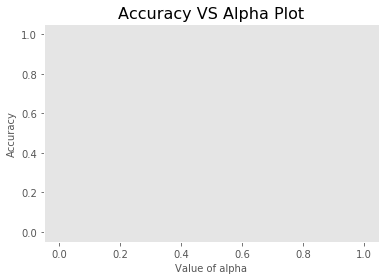


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [84]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [93]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [ ]:
print(classification_report(y_test , pred))

## SVM on AVG-W2V

In [94]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

68.08929743926461


In [95]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.840332,0.263036,1.486825,0.067569,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,10.895617,1.752731,1.592542,0.140399,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,12.464674,0.093567,1.402454,0.047033,1,{'C': 1},0.649425,0.588670,0.662562,0.660920,...,0.633826,0.030108,4,0.639984,0.630131,0.635057,0.649015,0.623974,0.635632,0.008539
3,10.489356,0.235231,1.400010,0.116877,10,{'C': 10},0.710181,0.655993,0.711002,0.692939,...,0.690476,0.020357,3,0.690066,0.706281,0.691502,0.696223,0.697660,0.696346,0.005716
4,10.160362,0.628401,1.620206,0.036015,100,{'C': 100},0.720033,0.692939,0.722496,0.700328,...,0.706404,0.012382,2,0.706281,0.715517,0.710591,0.715312,0.716133,0.712767,0.003799
5,11.992552,2.160685,1.479843,0.412231,1000,{'C': 1000},0.738916,0.690476,0.726601,0.711002,...,0.715271,0.016465,1,0.734401,0.743432,0.730296,0.744048,0.738095,0.738054,0.005261


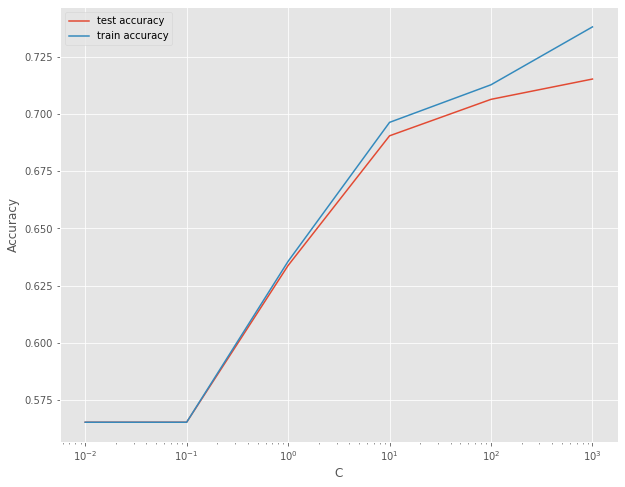

In [96]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [97]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.498198,0.477776,2.063755,0.266146,1,{'gamma': 1},0.683908,0.672414,0.679803,0.688013,...,0.674713,0.013654,4,0.973112,0.974343,0.973112,0.972291,0.972701,0.973112,0.000687
1,9.654988,0.080048,1.333833,0.168502,0.1,{'gamma': 0.1},0.738916,0.678982,0.722496,0.709360,...,0.710509,0.020027,1,0.779762,0.780583,0.776683,0.780788,0.781609,0.779885,0.001705
2,9.627661,0.155146,1.315479,0.109907,0.01,{'gamma': 0.01},0.712644,0.665846,0.701970,0.693760,...,0.693268,0.015522,2,0.701560,0.710181,0.704639,0.706486,0.706897,0.705952,0.002831
3,9.098075,0.483476,1.171867,0.054596,0.001,{'gamma': 0.001},0.694581,0.642036,0.701149,0.688834,...,0.679475,0.021274,3,0.683703,0.690271,0.683498,0.685961,0.686371,0.685961,0.002446
4,11.288115,2.037079,1.704048,0.189839,0.0001,{'gamma': 0.0001},0.582102,0.536946,0.574713,0.593596,...,0.566010,0.022289,5,0.564655,0.572250,0.563013,0.561782,0.571018,0.566544,0.004273


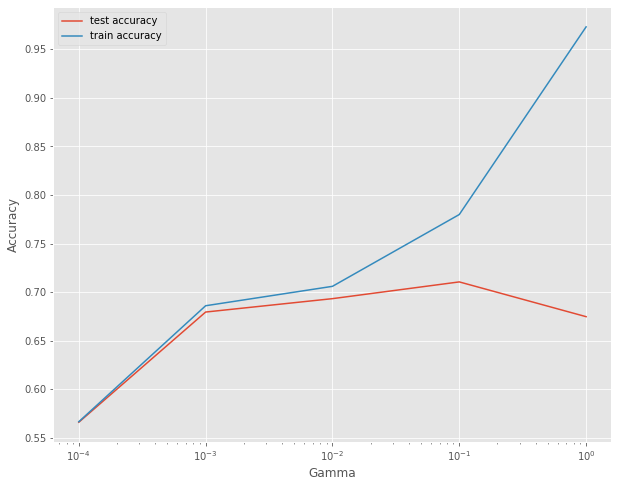

In [98]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [99]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 1000}
{'gamma': 0.1}


In [114]:
sv = SVC(C = 1000 , gamma = 0.1)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

67.82665791201575


In [115]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:17<00:00,  1.98s/it]


In [116]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.000.


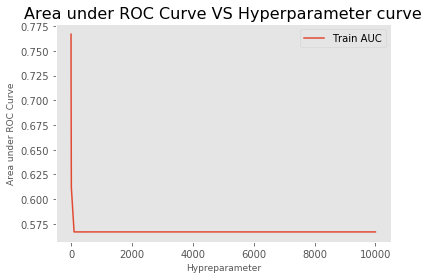

In [103]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.0001
AUC =  69.8408666324406


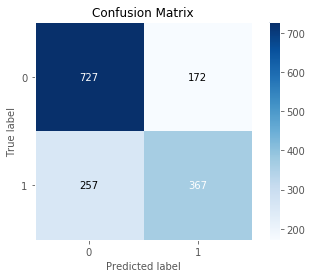

In [104]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on AVG-W2V

In [117]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

64.67498358502954


In [118]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.160892,0.091491,0.002394,0.001353,20,{'min_samples_split': 20},0.633826,0.635468,0.631363,0.622332,...,0.633826,0.007649,9,0.894499,0.899836,0.891831,0.890189,0.903120,0.895895,0.004873
1,1.251851,0.079476,0.002593,0.001739,40,{'min_samples_split': 40},0.629721,0.646962,0.624795,0.631363,...,0.635468,0.008689,8,0.837233,0.849343,0.833128,0.840517,0.842365,0.840517,0.005417
2,1.081906,0.113335,0.005789,0.005476,60,{'min_samples_split': 60},0.650246,0.639573,0.629721,0.637110,...,0.641379,0.007933,7,0.804803,0.813834,0.806034,0.812397,0.800287,0.807471,0.005011
3,0.999722,0.045388,0.005587,0.007688,80,{'min_samples_split': 80},0.655172,0.638752,0.637110,0.644499,...,0.645977,0.007585,6,0.786535,0.796798,0.781199,0.785920,0.775246,0.785140,0.007098
4,1.074326,0.069325,0.001597,0.000797,100,{'min_samples_split': 100},0.664204,0.640394,0.637931,0.645320,...,0.647619,0.009309,5,0.771757,0.772578,0.764573,0.770936,0.769089,0.769787,0.002852
5,0.892812,0.066367,0.002197,0.001933,120,{'min_samples_split': 120},0.664204,0.659278,0.636289,0.638752,...,0.649589,0.010971,4,0.750616,0.757800,0.758415,0.755952,0.756979,0.755952,0.002793
6,0.865484,0.029698,0.001595,0.000488,140,{'min_samples_split': 140},0.654351,0.664204,0.640394,0.633826,...,0.650082,0.011250,2,0.745895,0.753284,0.755542,0.745690,0.746305,0.749343,0.004205
7,0.834166,0.043532,0.001995,0.000631,160,{'min_samples_split': 160},0.648604,0.662562,0.644499,0.635468,...,0.649754,0.009583,3,0.740764,0.741379,0.747947,0.743842,0.736453,0.742077,0.003779
8,0.785099,0.122211,0.001397,0.000488,180,{'min_samples_split': 180},0.655172,0.665846,0.647783,0.642036,...,0.654351,0.008611,1,0.735222,0.736043,0.739327,0.730296,0.733374,0.734852,0.002984


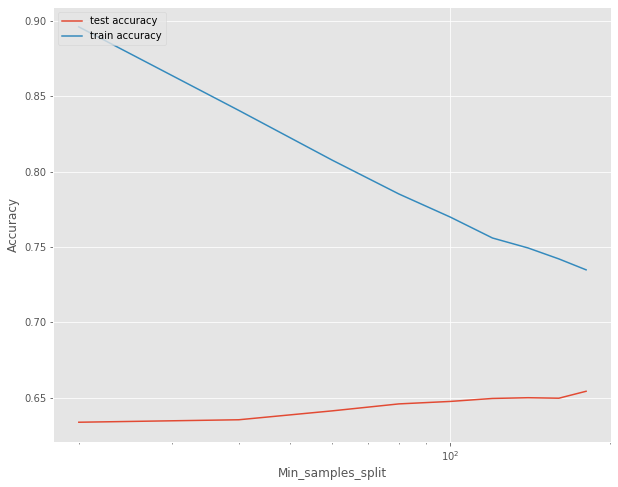

In [119]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [120]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.112023,0.034921,0.001601,0.000492,1,{'min_samples_leaf': 1},0.636289,0.637110,0.633826,0.632184,...,0.633333,0.003506,17,0.986248,0.986658,0.985427,0.985222,0.986043,0.985920,0.000529
1,1.167875,0.053434,0.003990,0.005007,2,{'min_samples_leaf': 2},0.648604,0.646962,0.633005,0.645320,...,0.644663,0.005997,4,0.956486,0.960181,0.961412,0.957512,0.959770,0.959072,0.001806
2,1.173860,0.018680,0.002994,0.002091,3,{'min_samples_leaf': 3},0.629721,0.637110,0.626437,0.634647,...,0.633990,0.005481,15,0.940887,0.943555,0.944581,0.945608,0.944171,0.943760,0.001585
3,1.303913,0.065471,0.001996,0.000631,4,{'min_samples_leaf': 4},0.628079,0.646141,0.623153,0.652709,...,0.638588,0.011166,9,0.921182,0.923851,0.925493,0.919335,0.925903,0.923153,0.002529
4,1.234697,0.123888,0.002394,0.000798,5,{'min_samples_leaf': 5},0.627258,0.631363,0.628900,0.638752,...,0.633990,0.006240,15,0.906199,0.906814,0.902915,0.906199,0.910099,0.906445,0.002283
5,1.014288,0.032938,0.002595,0.001196,6,{'min_samples_leaf': 6},0.654351,0.644499,0.640394,0.640394,...,0.647619,0.007442,2,0.891420,0.895320,0.890394,0.887726,0.893268,0.891626,0.002573
6,1.210168,0.150103,0.002391,0.001016,7,{'min_samples_leaf': 7},0.653530,0.659278,0.653530,0.634647,...,0.648604,0.008949,1,0.876847,0.882184,0.879310,0.879516,0.881773,0.879926,0.001925
7,1.658368,0.204243,0.002389,0.001354,8,{'min_samples_leaf': 8},0.655993,0.631363,0.635468,0.623153,...,0.640722,0.013734,7,0.863300,0.866174,0.863095,0.868432,0.871921,0.866585,0.003317
8,1.232501,0.114312,0.001797,0.000399,9,{'min_samples_leaf': 9},0.662562,0.641215,0.628900,0.611658,...,0.639737,0.018125,8,0.850985,0.853243,0.855296,0.855501,0.863095,0.855624,0.004077
9,1.313086,0.194893,0.003392,0.002862,10,{'min_samples_leaf': 10},0.656814,0.639573,0.619869,0.605911,...,0.634154,0.018726,14,0.842159,0.843391,0.848112,0.849548,0.852833,0.847209,0.003949


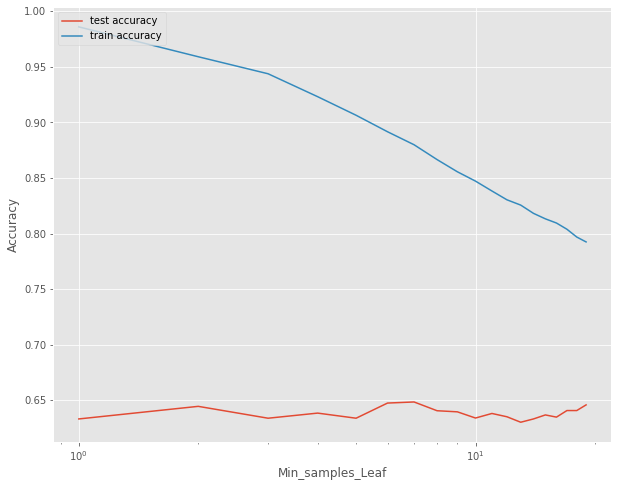

In [121]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [122]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.180716,0.083438,0.002792,2.631086e-03,1,{'max_depth': 1},0.604269,0.594417,0.570608,0.597701,...,0.591297,0.011405,19,0.597906,0.600164,0.582102,0.598727,0.601601,0.596100,0.007112
1,0.494076,0.099125,0.004389,1.353387e-03,2,{'max_depth': 2},0.644499,0.633005,0.611658,0.642857,...,0.630213,0.012967,17,0.638547,0.643062,0.642447,0.638342,0.640599,0.640599,0.001939
2,0.589624,0.053164,0.009574,1.275009e-02,3,{'max_depth': 3},0.646962,0.639573,0.611658,0.633826,...,0.627586,0.016010,18,0.643883,0.653325,0.642447,0.643473,0.643268,0.645279,0.004050
3,0.710302,0.113067,0.003191,2.631697e-03,4,{'max_depth': 4},0.669951,0.663383,0.644499,0.632184,...,0.654023,0.013754,2,0.678571,0.680008,0.665230,0.682677,0.683087,0.677915,0.006560
4,0.945677,0.220010,0.004782,6.116828e-03,5,{'max_depth': 5},0.668309,0.667488,0.652709,0.651888,...,0.657964,0.008187,1,0.694787,0.694992,0.698481,0.703202,0.699302,0.698153,0.003106
5,0.749393,0.072190,0.002394,4.885971e-04,6,{'max_depth': 6},0.665846,0.656814,0.648604,0.646962,...,0.651888,0.008580,3,0.710591,0.727422,0.725369,0.729885,0.722291,0.723112,0.006738
6,0.726854,0.045290,0.001996,8.714517e-07,7,{'max_depth': 7},0.676519,0.658456,0.635468,0.646141,...,0.651724,0.014487,4,0.743021,0.755747,0.752874,0.752668,0.758621,0.752586,0.005253
7,0.785301,0.032959,0.003394,2.790887e-03,8,{'max_depth': 8},0.665025,0.663383,0.626437,0.643678,...,0.648112,0.014461,6,0.776683,0.789204,0.793924,0.787972,0.791872,0.787931,0.005993
8,0.821406,0.025304,0.001793,3.977264e-04,9,{'max_depth': 9},0.664204,0.638752,0.625616,0.639573,...,0.645977,0.014755,8,0.812397,0.833744,0.831486,0.827997,0.826970,0.826519,0.007466
9,0.934301,0.030736,0.001996,6.316558e-04,10,{'max_depth': 10},0.661741,0.649425,0.630542,0.652709,...,0.647619,0.010351,7,0.842570,0.860427,0.870484,0.861864,0.873974,0.861864,0.010911


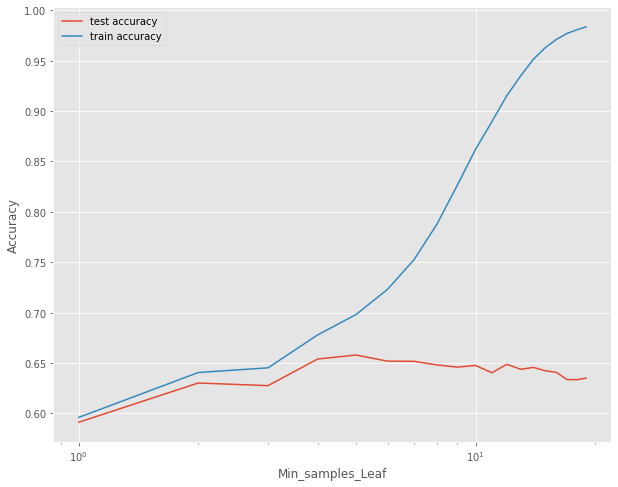

In [123]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [124]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 180}
{'min_samples_leaf': 7}
{'max_depth': 5}


In [126]:
dt = DecisionTreeClassifier(max_depth = 5 , min_samples_leaf = 7 , min_samples_split = 100)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

68.74589625738675


***Test Data Report***
Best max_depth =  5
Best min_samples_split =  100
AUC =  69.8408666324406


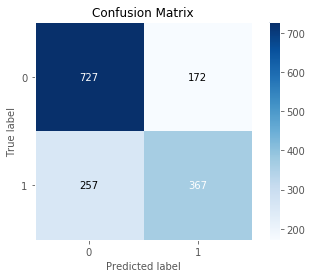

In [128]:
optimal_depth = 5
optimal_split = 100

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on AVG-W2V

In [129]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.9836751495371598


In [130]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7229152987524623

In [131]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.041222,0.017395,0.004654,0.000469,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.608157,0.646377,0.614670,0.623068,0.016695,25,0.603307,0.658392,0.621268,0.627656,0.022938
1,0.115026,0.024434,0.007314,0.001880,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.611260,0.638716,0.664814,0.638263,0.021865,23,0.630780,0.668866,0.679337,0.659661,0.020865
2,0.190154,0.015648,0.008644,0.000470,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.662746,0.634595,0.688611,0.661984,0.022058,19,0.673239,0.684681,0.697224,0.685048,0.009795
3,0.849396,0.105556,0.024934,0.002935,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.682152,0.667480,0.683677,0.677770,0.007302,18,0.695965,0.702990,0.702419,0.700458,0.003186
4,1.765945,0.029499,0.059509,0.010311,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.683664,0.671770,0.696189,0.683874,0.009970,17,0.694934,0.705246,0.714216,0.704799,0.007878


C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



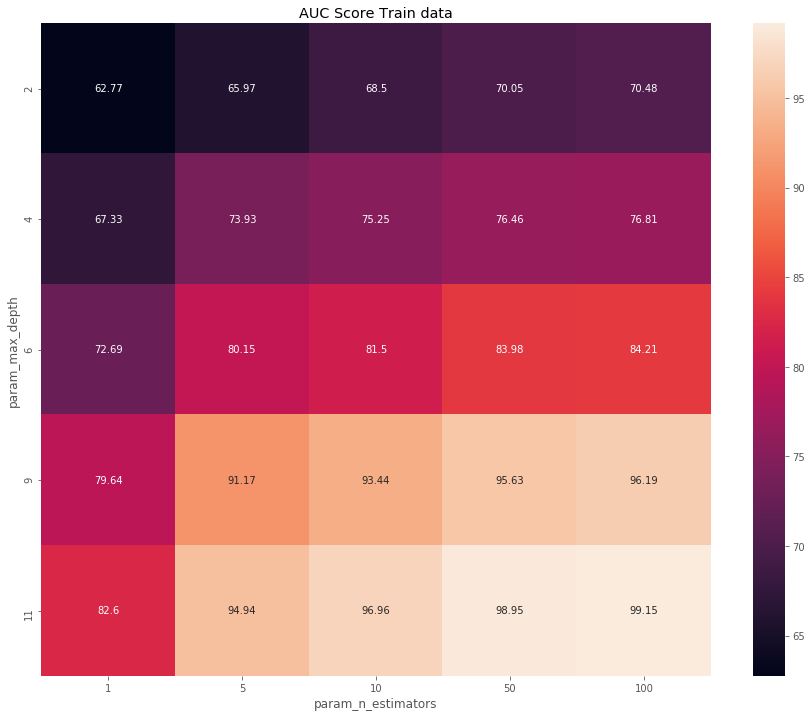

In [132]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



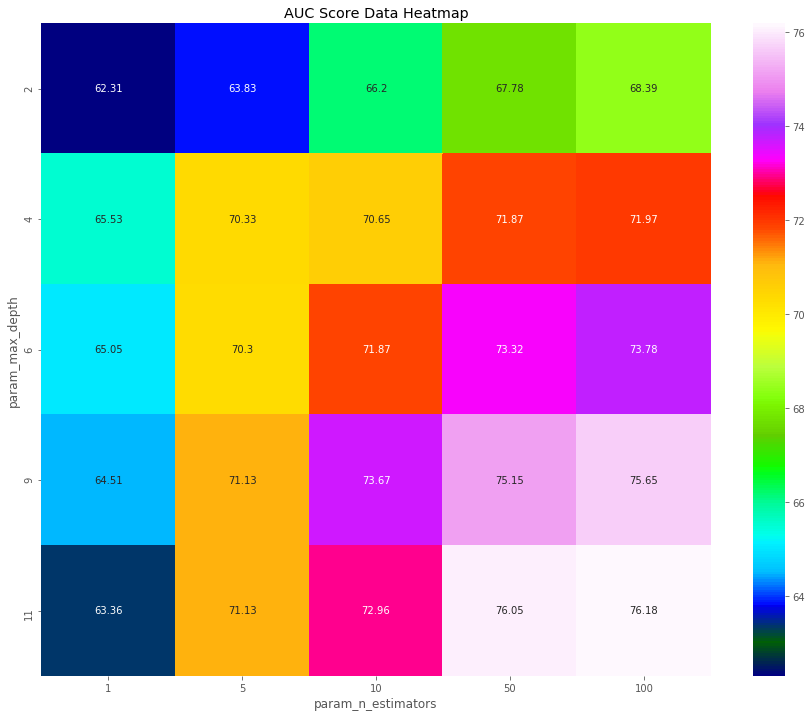

In [133]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  50.11123470522803


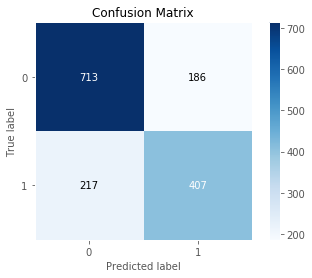

In [136]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(x_train_w2v , y_train)
pred = lr.predict(x_test_w2v)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [137]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

73.34208798424163


In [ ]:
test_pred = rf.predict(test_w2v)

In [ ]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [138]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,2.288085,0.056037,0.040989,0.010215,2,{'max_depth': 2},0.637110,0.622332,0.627258,0.642036,...,0.640577,0.645685,0.645868,0.643313,0.644773,0.643678,0.646415,0.640941,0.642729,0.003236
1,4.293421,0.151759,0.051262,0.024884,4,{'max_depth': 4},0.671593,0.674877,0.668309,0.663383,...,0.684729,0.683999,0.681263,0.684729,0.687466,0.687648,0.687101,0.688196,0.685222,0.002354
2,5.566094,0.510396,0.047176,0.029339,6,{'max_depth': 6},0.692939,0.694581,0.711002,0.691297,...,0.743113,0.742200,0.742018,0.739099,0.744390,0.741835,0.744025,0.741653,0.741927,0.002937
3,7.513698,0.856589,0.050565,0.029683,8,{'max_depth': 8},0.704433,0.732348,0.732348,0.697865,...,0.811166,0.804415,0.811348,0.817916,0.814997,0.806057,0.814632,0.814085,0.811367,0.003998
4,9.178160,0.812904,0.054655,0.015705,10,{'max_depth': 10},0.711002,0.720854,0.732348,0.704433,...,0.893997,0.890713,0.899288,0.892720,0.896552,0.891443,0.894545,0.896552,0.894052,0.002625


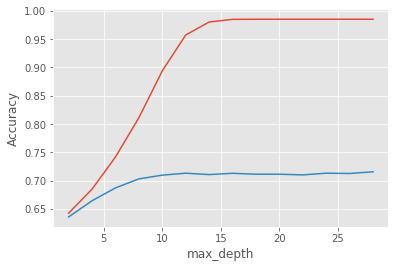

In [139]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [140]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 350}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.486534,0.365382,0.040888,0.007137,50,{'n_estimators': 50},0.712644,0.698686,0.721675,0.695402,...,0.706076,0.009714,9,0.985837,0.986658,0.985222,0.985016,0.986043,0.985755,0.000589
1,9.360768,1.202791,0.055054,0.003241,100,{'n_estimators': 100},0.712644,0.706076,0.723317,0.695402,...,0.707553,0.009761,8,0.986248,0.986658,0.985427,0.985222,0.986043,0.985920,0.000529
2,11.257838,0.421335,0.098534,0.016606,150,{'n_estimators': 150},0.724138,0.706076,0.721675,0.697865,...,0.709852,0.011035,7,0.986248,0.986658,0.985427,0.985222,0.986043,0.985920,0.000529
3,17.350289,0.481454,0.139228,0.020405,200,{'n_estimators': 200},0.723317,0.720033,0.715928,0.693760,...,0.712151,0.010573,5,0.986248,0.986658,0.985427,0.985222,0.986043,0.985920,0.000529
4,26.329697,1.561190,0.181515,0.040182,250,{'n_estimators': 250},0.722496,0.714286,0.716749,0.698686,...,0.711987,0.008167,6,0.986248,0.986658,0.985427,0.985222,0.986043,0.985920,0.000529


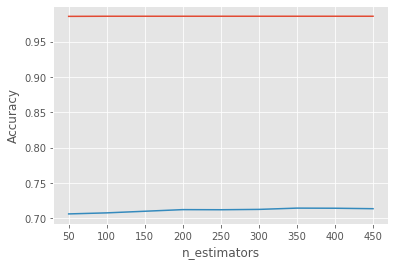

In [141]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [142]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.675511,1.169314,0.055851,0.021222,30,{'min_samples_leaf': 30},0.703612,0.702791,0.716749,0.685550,...,0.701314,0.010061,1,0.774425,0.783046,0.778736,0.778736,0.780788,0.779146,0.002847
1,2.756701,0.415990,0.031535,0.002074,80,{'min_samples_leaf': 80},0.694581,0.697044,0.704433,0.673235,...,0.691461,0.010519,2,0.725164,0.729475,0.727217,0.726396,0.729680,0.727586,0.001753
2,2.313366,0.263463,0.029828,0.004792,130,{'min_samples_leaf': 130},0.696223,0.688834,0.690476,0.670772,...,0.686043,0.008589,3,0.701970,0.714696,0.705870,0.708128,0.711207,0.708374,0.004366
3,2.344995,0.270862,0.045392,0.013422,180,{'min_samples_leaf': 180},0.688834,0.685550,0.689655,0.663383,...,0.680460,0.010034,4,0.694992,0.698071,0.699713,0.700123,0.703818,0.699343,0.002875
4,1.777990,0.062243,0.033022,0.011444,230,{'min_samples_leaf': 230},0.690476,0.682266,0.684729,0.663383,...,0.677176,0.010934,5,0.689860,0.693350,0.690681,0.696634,0.695197,0.693144,0.002580


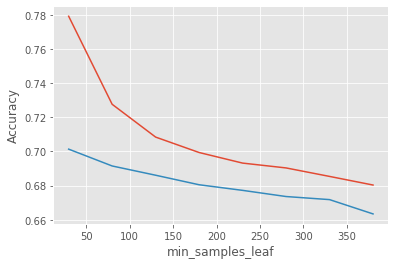

In [143]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [144]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.072316,0.465161,0.072207,0.027266,10,{'min_samples_split': 10},0.715928,0.713465,0.717570,0.690476,...,0.708210,0.010104,1,0.980706,0.979680,0.979269,0.976601,0.980296,0.979310,0.001442
1,6.860659,0.962073,0.108413,0.058372,60,{'min_samples_split': 60},0.713465,0.710181,0.708539,0.692118,...,0.707389,0.007834,2,0.827997,0.831281,0.825944,0.824918,0.827997,0.827627,0.002181
2,6.443683,0.485672,0.059641,0.005255,110,{'min_samples_split': 110},0.709360,0.707718,0.712644,0.697044,...,0.703284,0.008589,3,0.778325,0.783046,0.779762,0.777299,0.780583,0.779803,0.001979
3,5.652041,0.077045,0.052061,0.005255,160,{'min_samples_split': 160},0.708539,0.704433,0.702791,0.680624,...,0.698030,0.009953,4,0.755337,0.758415,0.754516,0.751437,0.758415,0.755624,0.002624
4,5.585622,0.237336,0.050665,0.016136,210,{'min_samples_split': 210},0.706076,0.697044,0.701149,0.680624,...,0.694089,0.009555,5,0.739122,0.740558,0.735222,0.739737,0.737685,0.738465,0.001874


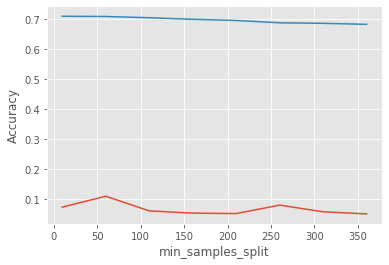

In [145]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [146]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 10}
Best parameter for n_estimators:  {'n_estimators': 350}


In [148]:
new_rf = RandomForestClassifier(n_estimators = 350 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 10)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

73.7360472751149


## GBDT on AVG-W2V

In [149]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

71.70059093893632


In [150]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [151]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.455360,2.146269,0.004841,0.004327,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,23.203721,0.150759,0.006616,0.003688,0.01,{'learning_rate': 0.01},0.675698,0.655993,0.652709,0.660099,0.652709,0.659442,0.008570,3
2,24.077985,0.150002,0.008244,0.006294,0.1,{'learning_rate': 0.1},0.708539,0.706897,0.701149,0.698686,0.681445,0.699343,0.009650,1
3,23.362419,0.289030,0.006248,0.007653,1,{'learning_rate': 1.0},0.675698,0.656814,0.660099,0.672414,0.648604,0.662726,0.010034,2
4,22.295160,2.016845,0.009373,0.007653,1.3,{'learning_rate': 1.3},0.678982,0.633005,0.655993,0.625616,0.633826,0.645484,0.019591,4


In [152]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [153]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.455360,2.146269,0.004841,0.004327,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,23.203721,0.150759,0.006616,0.003688,0.01,{'learning_rate': 0.01},0.675698,0.655993,0.652709,0.660099,0.652709,0.659442,0.008570,3
2,24.077985,0.150002,0.008244,0.006294,0.1,{'learning_rate': 0.1},0.708539,0.706897,0.701149,0.698686,0.681445,0.699343,0.009650,1
3,23.362419,0.289030,0.006248,0.007653,1,{'learning_rate': 1.0},0.675698,0.656814,0.660099,0.672414,0.648604,0.662726,0.010034,2
4,22.295160,2.016845,0.009373,0.007653,1.3,{'learning_rate': 1.3},0.678982,0.633005,0.655993,0.625616,0.633826,0.645484,0.019591,4


In [154]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 1.0 ,  n_estimators=150)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

66.57912015758372


## XGB on AVG-W2V

In [155]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

72.16021011162181


In [156]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.9993550861946091


***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  50.11123470522803


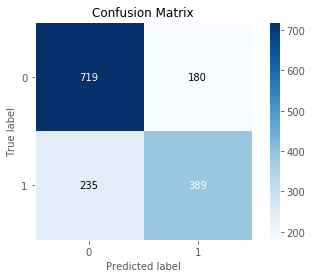

In [159]:
optimal_depth = 11
optimal_estimators = 100

xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [158]:
# test_pred = xg_model.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02xgb.csv', index=False)